- Create a BA graph with 300 nodes
- Assign each player(node) a marksmanship, “which can take on one of the three possible values: [0.5, 0.8, 1]. Marksmanship levels are randomly distributed in the network with equal initial proportions.”
- “At each step in the game: one node is chosen randomly. 
	- This chosen player, in turn, randomly selects two opponents among his neighbour nodes, and the three players play a sequential truel with a fixed shooting order. 
	- However, if the initially chosen player has only one neighbour, a duel occurs. 
	- Moreover, players are assumed to be rational (i.e., they strictly follow the strongest opponent strategy but never aim at a player of the same type). 
	- Finally, the losers of either a truel or a duel are removed from the network, and if a node has no neighbours left, it will be reattached to the network along the lines of the preferential-attachment algorithm that was used to create the scale-free network.
	- In the unlikely event that no strongest player exists because all players chosen have the same level of marksmanship, no duel or truel will be played. In this case, a new node and its neighbours will be randomly selected to continue the game.”
- The program will iterate until no more duels or truels can be played under these rules



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

In [ ]:
# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py
# by Allen Downey
import random

def barabasi_albert_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

In [ ]:
def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

In [ ]:
def flip(p):
    return np.random.random() < p

Code below assigns marksmanships to each player and show that it works.

In [ ]:
def assign_marksmanships(G):
  marksmanships = [0.5, 0.8, 1]
  for node in G.nodes():
    G.nodes[node]["marksmanship"] = random.choice(marksmanships)

In [ ]:
G = barabasi_albert_graph(n = 300, k =10)
assign_marksmanships(G)

print(G.nodes.data())

[(0, {'marksmanship': 0.5}), (1, {'marksmanship': 1}), (2, {'marksmanship': 0.8}), (3, {'marksmanship': 0.8}), (4, {'marksmanship': 0.5}), (5, {'marksmanship': 0.8}), (6, {'marksmanship': 1}), (7, {'marksmanship': 0.5}), (8, {'marksmanship': 1}), (9, {'marksmanship': 1}), (10, {'marksmanship': 0.8}), (11, {'marksmanship': 1}), (12, {'marksmanship': 1}), (13, {'marksmanship': 0.8}), (14, {'marksmanship': 0.8}), (15, {'marksmanship': 0.5}), (16, {'marksmanship': 0.8}), (17, {'marksmanship': 0.5}), (18, {'marksmanship': 1}), (19, {'marksmanship': 0.8}), (20, {'marksmanship': 0.8}), (21, {'marksmanship': 0.8}), (22, {'marksmanship': 0.8}), (23, {'marksmanship': 0.8}), (24, {'marksmanship': 0.5}), (25, {'marksmanship': 0.8}), (26, {'marksmanship': 0.5}), (27, {'marksmanship': 1}), (28, {'marksmanship': 0.8}), (29, {'marksmanship': 0.5}), (30, {'marksmanship': 0.5}), (31, {'marksmanship': 0.5}), (32, {'marksmanship': 0.5}), (33, {'marksmanship': 1}), (34, {'marksmanship': 0.8}), (35, {'marks

We then define the types of duels/truels in the paper. The first is how the paper defined a random duel, which is when the players are shuffled and the person who shoots first is random. A sequential duel is when the person who shoots first is decided, and a sequential truel is a truel where the shooting order is decided based off of marksmanship, from weakest to strongest.

In [ ]:
def random_duel(G, players):
  while len(players) == 2 :
    random.shuffle(players)
    a = players[0]
    if flip(G.nodes[a]["marksmanship"]):
      b = players.pop(1)
      G.remove_node(b)

In [ ]:
def sequential_duel(G, players, marksmanships, starting_player = None):
  players.sort(key=lambda player: marksmanships[player], reverse=False)

  if starting_player == None:
    [starting_player, other_player] = players
  else:
    if starting_player == players[0]:
      other_player = players[1]
    else:
      other_player = players[0]

  players = [starting_player, other_player]

  # If marksmanships between players are equal, considered a tie
  if marksmanships[starting_player] == marksmanships[other_player]:
    #print("Tie in duel!")
    return players

  shot_count = 0
  while len(players) == 2 :
    player = players[shot_count%2]
    opponent = players[(shot_count+1)%2]
    if flip(marksmanships[player]):
      players.remove(opponent)
      G.remove_node(opponent)
  return players

In [ ]:
def sequential_truel(G, players, marksmanships):
  players.sort(key=lambda player: marksmanships[player], reverse=False)
  [c, b, a] = players

  #If marksmanships between players are same, considered a tie
  if marksmanships[c] == marksmanships[b] and marksmanships[c] == marksmanships[a]:
    #print("Tie!")
    return players

  #Formated x attack y (or z if x and y have same marksmanship)
  strongest_opponent_strategy = {c: [a,b], b: [a,c], a : [b, c]}

  shot_count = 0
  while len(players) == 3:
    player = players[shot_count%3]
    #if player hits
    if flip(marksmanships[player]):
      opponent_strong = strongest_opponent_strategy[player][0]
      opponent_weak = strongest_opponent_strategy[player][1]
      if marksmanships[player] != marksmanships[opponent_strong]:
        players.remove(opponent_strong)
        G.remove_node(opponent_strong)
      elif marksmanships[player] != marksmanships[opponent_weak]:
        players.remove(opponent_weak)
        G.remove_node(opponent_weak)
    shot_count += 1
    
  #Goes into a seqeuntial duel after one player is eliminated
  return sequential_duel(G, players, marksmanships, starting_player = players[shot_count%2])

This next code block tests the program so far by creating a Barabasi-Albert graph and performing one truel, with the output showing the resulting winner of the truel and their marksmanship.

In [ ]:
#Create BA graph and assign marksmanships
G = barabasi_albert_graph(n = 300, k = 10)
assign_marksmanships(G)
marksmanships = dict(list(G.nodes(data='marksmanship')))

#Get random player
players = [random.choice(list(G.nodes()))]
# if this player has at least two neighbors, go into a truel; otherwise, go into a duel
if len(G[players[0]]) > 1:
  players.extend(_random_subset(list(G[players[0]]), 2))
  players = sequential_truel(G, players, marksmanships)
else:
  players.append(G[players[0]])
  players = sequential_duel(G, players, marksmanships)

marksmanships = list(G.nodes(data='marksmanship'))
for player in players:
  print(player, marksmanships[player][1])

60 1
52 0.8


Make this into a stand alone function that can be repeated. That way, we can establish an end-case before it is called. 

In [ ]:
# Choose a random player and put them in a duel/truel

def make_player_compete(G, marksmanships, counter):
  """
  Make a random player in G compete in either a duel or truel
  depending on how many neighbors it has.
  """
  #Get random player
  players = [random.choice(list(G.nodes()))]
  check_marksmanships(players, marksmanships)
  # if this player has at least two neighbors, go into a truel; otherwise, go into a duel
  if len(G[players[0]]) > 1:
    players.extend(_random_subset(list(G[players[0]]), 2))
    #print("Battle " + str(counter) + ": ", players)
    players = sequential_truel(G, players, marksmanships)
  elif len(G[players[0]]) == 1:
    players.extend(_random_subset(list(G[players[0]]), 1))
    players = sequential_duel(G, players, marksmanships)
  #Clear list after done
  players = []

Now this next function defines the end case. The end-case holds to be true if, for every node in the graph:
- The node has either no neighbors, or
- The neighbors of the node have the same marksmanship as the original node.

In [ ]:
def check_for_end_case(G):
  """
  Returns True if end case as defined above is achieved. Returns False if not.
  """
  marksmanships = dict(list(G.nodes(data='marksmanship')))
  for n in G:
    #Check if the node has at least one neighbor
    neighbors = list(G[n])
    if len(set(marksmanships[neighbor] for neighbor in neighbors)) > 1:
      return False
  return True

Finally, the Hunger Games function is a function that does everything we need to do. It creates a BA graph, assigns marksmanships to every node, and makes players compete until there is no way for players to compete anymore. The output shows each battle, showing the list of each truel and duel. Every time there is a tie, either in the truel or the duel, that is printed out.

TODO: Currently, after about 130-140 battles, the program outputs an error that 'AtlasView' is unhashable. I am assuming this is referencing the "marksmanships" dictionary that is defined at the very beginning of the code; however, it has been referenced over 130 times and has done fine. Why does NetworkX think it is an AtlasView and how can we circumvent this?

In [ ]:
def hunger_games():
  G = barabasi_albert_graph(n=300, k=10)
  assign_marksmanships(G)
  marksmanships = dict(list(G.nodes(data='marksmanship')))

  finished = False
  battle_count = 0
  # While there are less than 100,000 battles or the end case is not reached
  while (battle_count < 100000) and (finished != True):
    battle_count += 1
    make_player_compete(G, marksmanships, battle_count)
    check_for_end_case(G)
  
  #Return the number of red, blue, and black players
  reds = []
  blues = []
  blacks = []
  for n in G:
    if marksmanships[n] == 1:
      reds.append(n)
    elif marksmanships[n] == 0.8:
      blues.append(n)
    else:
      blacks.append(n)
  
  return [len(reds), len(blues), len(blacks)]

print('reds, blues, and blacks', hunger_games())

reds, blues, and blacks [7, 30, 21]


Now, we can use Monte-Carlo experimentation to figure out the average number of red, blue, and black players, respectively, that will survive at the end of random conditions. We will loop through 10 random seeds, and for each starting condition, each one is run 10 times.

(NOTE: Currently, this program runs through 10 million duels/truels and can take approximately a half-hour to run.)

In [ ]:
def monte_carlo(seed, k):
  """
  Runs the simulation k times for a random seed.
  """
  np.random.seed(seed)
  res = np.array([0.0,0.0,0.0])
  for _ in range(k):
    winners = np.array(hunger_games())
    res += winners
  return res/k

#########
res = np.array([0.0,0.0,0.0])
for seed in range(10):
  winners = monte_carlo(seed, 10)
  res += winners
res = (res/10).tolist()
print(res)

[8.959999999999999, 27.919999999999998, 20.45]


Create a bar graph of the results, by percentage.

Text(0.5, 1.0, 'Average Percentages of Each Player Remaining')

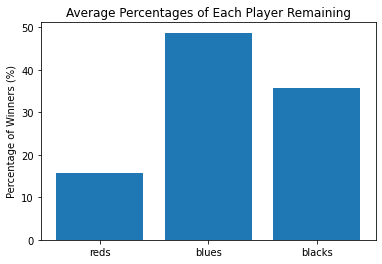

In [ ]:
reds, blues, blacks = res
sum = reds + blues + blacks
percent_reds = reds/sum * 100
percent_blues = blues/sum * 100
percent_blacks = blacks/sum * 100

x = ['reds', 'blues', 'blacks']
y = [percent_reds, percent_blues, percent_blacks]

plt.bar(x,y)
plt.ylabel('Percentage of Winners (%)')
plt.title('Average Percentages of Each Player Remaining')

The figure above shows that in truels where players are logical, red players, or the stronger players, are more likely to get eliminated, which lines up with the general conclusion of traditional game theory that stronger players will lose faster. On average, blue players and black players, with marksmanships `p = 0.8` and `p = 0.5`, respectively, make up approximately 84.4% of the players who survive the truels.